# Sales Forecasting 

This notebook focuses on forecasting future sales using historical e-commerce transactional data.
The objective is to analyze sales trends and seasonality, evaluate forecasting performance, and predict future revenue to support business planning and decision-making.

### Key Steps
- Aggregate transactional data into a time-series format
- Analyze historical sales trends
- Build evaluate a time-series forecasting model
- Forecast future sales for upcoming period

The insights from this analysis help businesses plan revenue targets, manage inventory, and make informed strategic decisions.

In [2]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

# plot style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)

In [3]:
# load data 
print("\n===== LOADING DATA =====")
master_df = pd.read_csv("OneDrive/Documents/Customer Sales Analytics/master_table_processed.csv")
master_df["order_purchase_timestamp"] = pd.to_datetime(master_df["order_purchase_timestamp"])

print(f"Orders loaded: {len(master_df):,}")
print(f"Data range: {master_df['order_purchase_timestamp'].min()} to {master_df['order_purchase_timestamp'].max()}")


===== LOADING DATA =====
Orders loaded: 96,478
Data range: 2016-09-15 12:16:38 to 2018-08-29 15:00:37


In [9]:
master_df.head(4)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,order_month,order_day_of_week,is_weeknd,year_month,avg_item_price,freight_percentage,satisfaction_score,is_weekend,is_extreme_delay,delivery_time_days_capped
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,10,0,0,2017-10,29.99,22.526479,4.0,0,0,8.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,7,1,0,2018-07,118.70,16.089354,4.0,0,0,13.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,8,2,0,2018-08,159.90,10.730237,5.0,0,0,9.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,...,11,5,1,2017-11,45.00,37.673130,5.0,1,0,13.0


# Aggregate to Daily Sales

In [11]:
# aggregate to daily sales

daily_sales = (
    master_df
    .groupby(master_df["order_purchase_timestamp"].dt.date)
    .agg(
        orders=("order_id", "count"),
        revenue=("order_revenue", "sum")
    )
    .reset_index()
)

daily_sales.columns = ["date", "orders", "revenue"]
daily_sales["date"] = pd.to_datetime(daily_sales["date"])
daily_sales = daily_sales = daily_sales.sort_values("date").reset_index(drop=True)

print(f"Daily records: {len(daily_sales)}")
print(f"\nDaily Sales Statistics:")
print(daily_sales[["orders", "revenue"]].describe())

Daily records: 612

Daily Sales Statistics:
            orders        revenue
count   612.000000     612.000000
mean    157.643791   25195.708742
std      89.507146   14370.467775
min       1.000000      19.620000
25%      97.750000   14812.260000
50%     145.500000   23272.330000
75%     213.250000   33617.777500
max    1147.000000  175178.460000


# Visualize Daily Sales


===== VISUALIATION SALES TRENDS =====


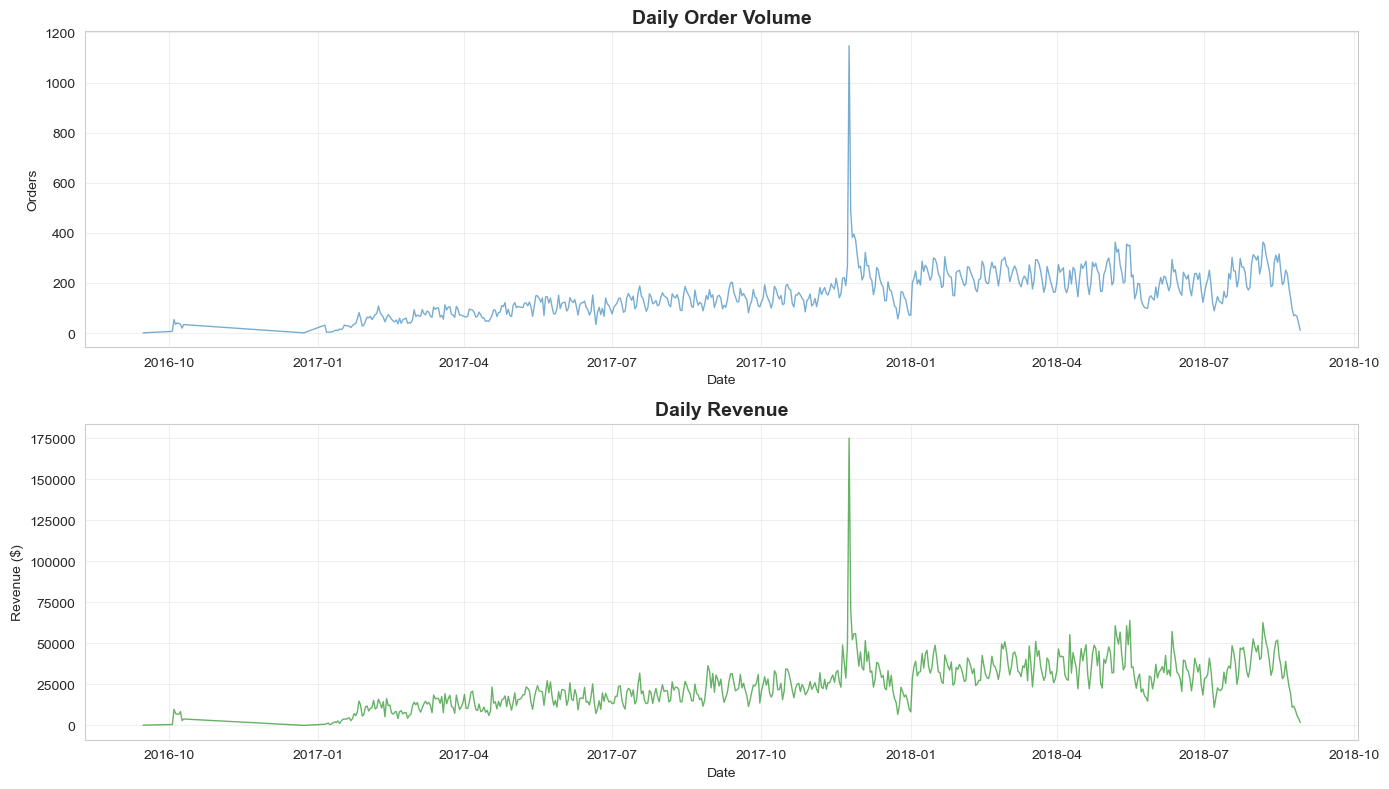

In [14]:
# visualize daily sales

print("\n===== VISUALIATION SALES TRENDS =====")

fig, ax = plt.subplots(2, 1, figsize=(14, 8))

# daily orders
ax[0].plot(daily_sales["date"], daily_sales["orders"], alpha=0.6, linewidth=1)
ax[0].set_title("Daily Order Volume", fontsize=14, fontweight="bold")
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Orders")
ax[0].grid(alpha=0.3)

# daily revenue
ax[1].plot(daily_sales["date"], daily_sales["revenue"], alpha=0.6, linewidth=1, color="green")
ax[1].set_title("Daily Revenue", fontsize=14, fontweight="bold")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Revenue ($)")
ax[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Convert Daily to Monthly (smoother data)

In [25]:
# resample to monthly
print("\n===== RESAMPLING TO MONTHLY =====")

# set data as index for resampling 
daily_sales_indexed = daily_sales.set_index("date")

# resample to weekly (sum orders and revenue per week)
monthly_sales = daily_sales_indexed.resample("M").agg({
    "orders": "sum",
    "revenue": "sum"
}).reset_index()

# check for zeroes
zero_months = (monthly_sales['revenue'] == 0).sum()
print(f"Months with zero revenue: {zero_months}")

# remove zeros if any
if zero_months > 0:
    monthly_sales = monthly_sales[monthly_sales['revenue'] > 0].reset_index(drop=True)
    print(f"After removing zeros: {len(monthly_sales)} months")

print(f"\nMonthly Sales Statistics:")
print(monthly_sales[["orders", "revenue"]].describe())


===== RESAMPLING TO MONTHLY =====
Months with zero revenue: 1
After removing zeros: 23 months

Monthly Sales Statistics:
            orders       revenue
count    23.000000  2.300000e+01
mean   4194.695652  6.704249e+05
std    2481.181398  3.951328e+05
min       1.000000  1.962000e+01
25%    2424.500000  4.025717e+05
50%    4193.000000  7.010775e+05
75%    6453.000000  1.019893e+06
max    7289.000000  1.153364e+06


# Visualize Monthly Sales


===== VISUALIZATION MONTHLY SALES TRENDS =====


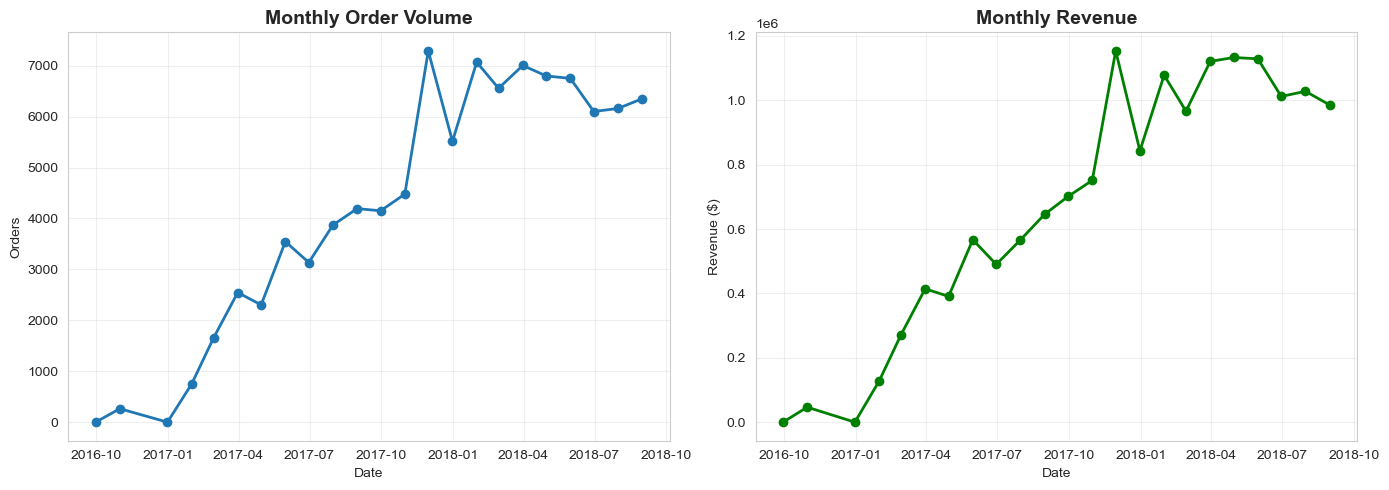

In [26]:
# visualize weekly sales
print("\n===== VISUALIZATION MONTHLY SALES TRENDS =====")

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# monthly orders
ax[0].plot(monthly_sales["date"], monthly_sales["orders"], marker="o", linewidth=2)
ax[0].set_title("Monthly Order Volume", fontsize=14, fontweight="bold")
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Orders")
ax[0].grid(alpha=0.3)

# monthly revenue
ax[1].plot(monthly_sales["date"], monthly_sales["revenue"], marker="o", linewidth=2, color="green")
ax[1].set_title("Monthly Revenue", fontsize=14, fontweight="bold")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Revenue ($)")
ax[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Train/Test Split

In [28]:
# train/test split
print("\n===== TRAIN/TEST SPLIT =====")

# use last 8 weeks as test set
test_months = 3
# python slicing
train_data = monthly_sales[:-test_months].copy() # all except last 3 months
test_data = monthly_sales[-test_months:].copy() # only last 3 months

print(f"Training data: {len(train_data)} months")
print(f"Test data: {len(test_data)} months")
print(f"Train date range: {train_data['date'].min()} to {train_data['date'].max()}")
print(f"Test date range: {test_data['date'].min()} to {test_data['date'].max()}")



===== TRAIN/TEST SPLIT =====
Training data: 20 months
Test data: 3 months
Train date range: 2016-09-30 00:00:00 to 2018-05-31 00:00:00
Test date range: 2018-06-30 00:00:00 to 2018-08-31 00:00:00


# Build SARIMAX Model

In [29]:
# SARIMAX model
print("\n===== BUILDING SARIMAX MODEL =====")

y_train = train_data["revenue"]
y_test = test_data["revenue"]

# SARIMAX parameters
# (p,d,q) X (P,D,Q,s)
# p,d,q: non-seasonal - AR, differencing, MA
# P,D,Q,s: seasonal - AR, differencing, MA, seasonal perod

# non-seasonal model
model = SARIMAX(
    y_train,
    order=(1, 1, 1),  # (p,d,q)
    seasonal_order=(0, 0, 0, 0),  # (P,D,Q,s) - 52 weeks yearly seasonality
    enforce_stationarity=False,
    enforce_invertibility=False
)

print("Fitting SARIMAX model...")
model_fit = model.fit(disp=False)
print("Model fitted sucessfully")


===== BUILDING SARIMAX MODEL =====
Fitting SARIMAX model...
Model fitted sucessfully


# Make Prediction

In [30]:
# making prediction
print("\n===== MAKING PREDICTIONS =====")

# prediction on test set
predictions = model_fit.forecast(steps=len(test_data))

# calculate metrics
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100

print(f"\nModel Performance")
print(f" MAE: ${mae:,.2f}")
print(f" RMSE: ${rmse:,.2f}")
print(f" MAPE: {mape:.2f}%")


===== MAKING PREDICTIONS =====

Model Performance
 MAE: $110,461.85
 RMSE: $111,458.36
 MAPE: 10.98%


# Visualize Predictions


===== VISUALIZING PREDICTIONS =====


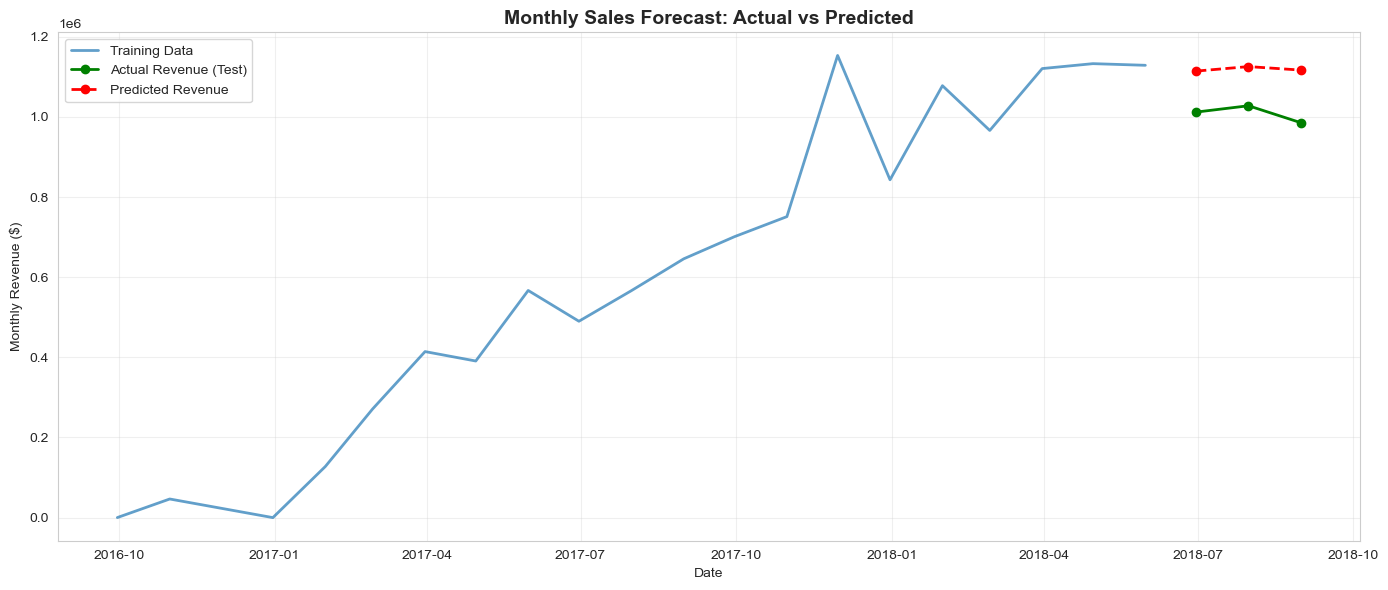

In [33]:
# visualize predictions
print("\n===== VISUALIZING PREDICTIONS =====")

fig, ax = plt.subplots(figsize=(14, 6))

# Training data
ax.plot(
    train_data["date"],
    y_train,
    label="Training Data",
    linewidth=2,
    alpha=0.7
)

# Actual test data
ax.plot(
    test_data["date"],
    y_test,
    label="Actual Revenue (Test)",
    linewidth=2,
    marker="o",
    color="green"
)

# Predicted values
ax.plot(
    test_data["date"],
    predictions,
    label="Predicted Revenue",
    linewidth=2,
    linestyle="--",
    marker="o",
    color="red"
)

ax.set_title("Monthly Sales Forecast: Actual vs Predicted",
             fontsize=14, fontweight="bold")
ax.set_xlabel("Date")
ax.set_ylabel("Monthly Revenue ($)")
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


# Forecast Next 6 Months

In [37]:
# forecast next 6 months
print("\n===== FORECASTING NEXT 6 MONTHS =====")

# refit model on full monthly data
final_model = SARIMAX (
    monthly_sales["revenue"],
    order=(1, 1, 1),
    seasonal_order=(0, 0, 0, 0),
    enforce_stationarity=False,
    enforce_invertibility=False
)

final_model_fit = final_model.fit(disp=False)

# forecast next 6 months
forecast_steps = 6
future_forecast = final_model_fit.forecast(steps=forecast_steps)

# create future data index
last_date = monthly_sales["date"].max()
future_dates = pd.date_range(
    start=last_date + pd.offsets.MonthEnd(1),
    periods=forecast_steps,
    freq="M"
)

# create forecast dataframe
forecast_6m = pd.DataFrame({
    "date": future_dates,
    "forecasted_revenue": future_forecast
})

print("\nNext 6 Months Revenue Forecast: ")
print(forecast_6m)


===== FORECASTING NEXT 6 MONTHS =====

Next 6 Months Revenue Forecast: 
         date  forecasted_revenue
23 2018-09-30        1.018726e+06
24 2018-10-31        9.898650e+05
25 2018-11-30        1.014928e+06
26 2018-12-31        9.931631e+05
27 2019-01-31        1.012064e+06
28 2019-02-28        9.956504e+05


# Visualize 6 Months Forecast

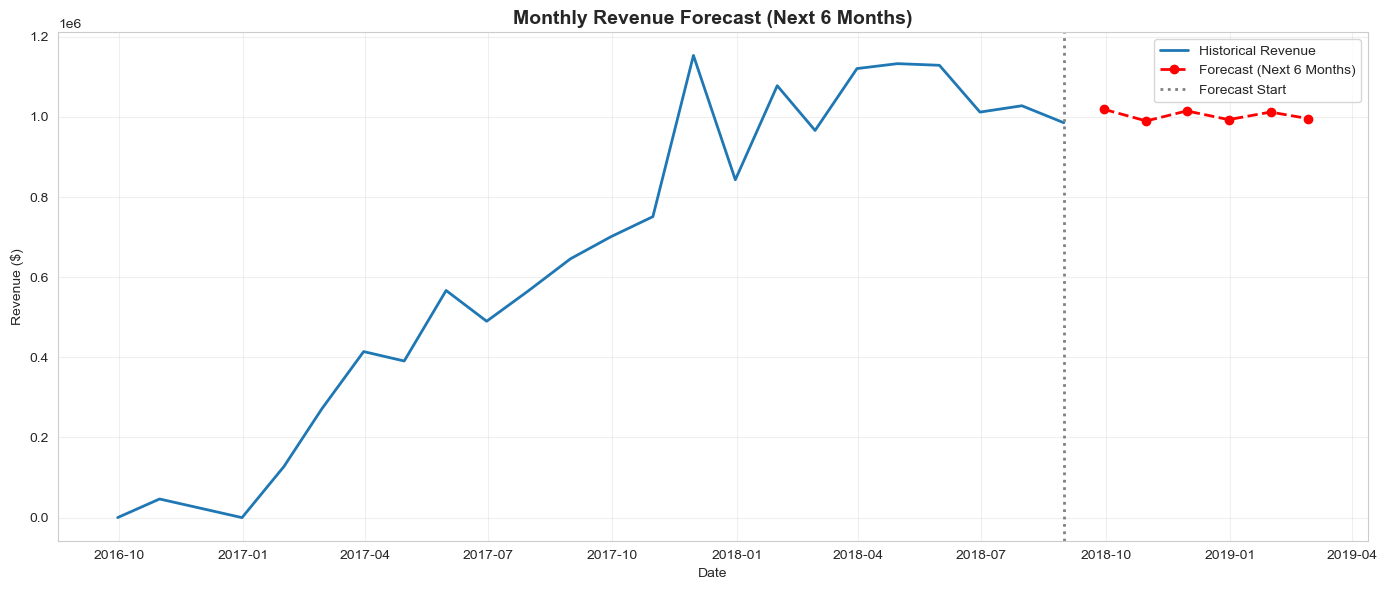

In [38]:
# visualize 6 months forecast

fig, ax = plt.subplots(figsize=(14, 6))

# Historical revenue
ax.plot(
    monthly_sales["date"],
    monthly_sales["revenue"],
    label="Historical Revenue",
    linewidth=2
)

# Forecasted revenue
ax.plot(
    forecast_6m["date"],
    forecast_6m["forecasted_revenue"],
    label="Forecast (Next 6 Months)",
    linestyle="--",
    marker="o",
    linewidth=2,
    color="red"
)

# Forecast start line
ax.axvline(
    x=last_date,
    color="gray",
    linestyle=":",
    linewidth=2,
    label="Forecast Start"
)

ax.set_title("Monthly Revenue Forecast (Next 6 Months)", fontsize=14, fontweight="bold")
ax.set_xlabel("Date")
ax.set_ylabel("Revenue ($)")
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


# Key Insights

In [39]:
# forecast summary (monthly)
print("\n===== FORECAST SUMMARY =====")

# total forecasted revenue for next 6 months
total_forecasted = forecast_6m["forecasted_revenue"].sum()

# average forecasted monthly revenue
avg_monthly_forecast = forecast_6m["forecasted_revenue"].mean()

# historical average monthly revenue
historical_avg_monthly = monthly_sales["revenue"].mean()

# growth rate
growth_rate = (
    (avg_monthly_forecast - historical_avg_monthly) 
    / historical_avg_monthly
) * 100

print(f"Historical average monthly revenue: ${historical_avg_monthly:,.2f}")
print(f"Forecasted average monthly revenue: ${avg_monthly_forecast:,.2f}")
print(f"Projected growth rate: {growth_rate:+.2f}%")
print(f"Total forecasted revenue (next 6 months): ${total_forecasted:,.2f}")



===== FORECAST SUMMARY =====
Historical average monthly revenue: $670,424.95
Forecasted average monthly revenue: $1,004,066.23
Projected growth rate: +49.77%
Total forecasted revenue (next 6 months): $6,024,397.37


# Sales Forecasting Summary

This notebook focuses on forecasting future sales revenue using historical order data.

---

### Data Preparation
- Order-level data was aggregated into **daily sales**, then resampled to a **monthly level** to reduce noise and improve model stability.
- The final dataset contains **23 months of valid revenue data** after removing zero-revenue months.
- Monthly aggregation was chosen as weekly forecasts showed high volatility and poor accuracy.

---

### Modeling Approach
- A **SARIMAX (ARIMA-based)** time series model was applied on monthly revenue.
- A simple non-seasonal configuration `(1,1,1)` was used due to limited data history.
- The last **3 months** were reserved as a test set to evaluate performance.

---

### Model Performance
- **MAE:** ~110k USD  
- **RMSE:** ~111k USD  
- **MAPE:** ~11%, indicating good short-term forecast accuracy for business data.

---

### 6-Month Revenue Forecast
- The model forecasts **stable monthly revenue around 1.0M USD** for the next 6 months.
- No extreme spikes or drops are observed, suggesting a steady revenue trend.

---

### Key Business Insights
- **Historical average monthly revenue:** ~670K USD  
- **Forecasted average monthly revenue:** ~1.00M USD
- **Projected growth rate:** ~50%, driven by strong recent performance rather than seasonality.
- **Total forecasted revenue (next 6 months):** ~6.0M USD

---

### Limitations
- The dataset spans only ~2 years, limiting long-term forecasting reliability.
- Forecasts are best interpreted as **short-term projections** based on recent trends.

---

### Conclusion
The monthly SARIMAX model provides a reliable short-term revenue forecast with low error and realistic behavior. These results can support budgeting, inventory planning, and strategic decision-making.

In [40]:
# save results
print("\n===== SAVING RESULTS =====")

forecast_6m.to_csv("OneDrive/Documents/Customer Sales Analytics/sales_forecast.csv", index=False)
print("\nForecast Saved")


===== SAVING RESULTS =====

Forecast Saved
